# Sound scene classifier for hearing aids

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
from sklearn.decomposition import PCA
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn as sk
from sklearn.metrics import accuracy_score
import os, sys
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchaudio
import torchaudio.transforms as T

Load andexplore the data set first

In [2]:
def show_audio(data):
    spectrogram_np = np.array(data)
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram_np, cmap='jet', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.show()

def npy_loader(path):
    return torch.from_numpy(np.load(path))



In [3]:
audioData = npy_loader('training.npy')
audioLabels = npy_loader('training_labels.npy')

torch.Size([52890, 32, 96])
torch.Size([52890])
Number of entries equal to 0: 14530
Number of entries equal to 1: 27340
Number of entries equal to 2: 4823
Number of entries equal to 3: 4412
Number of entries equal to 4: 1785


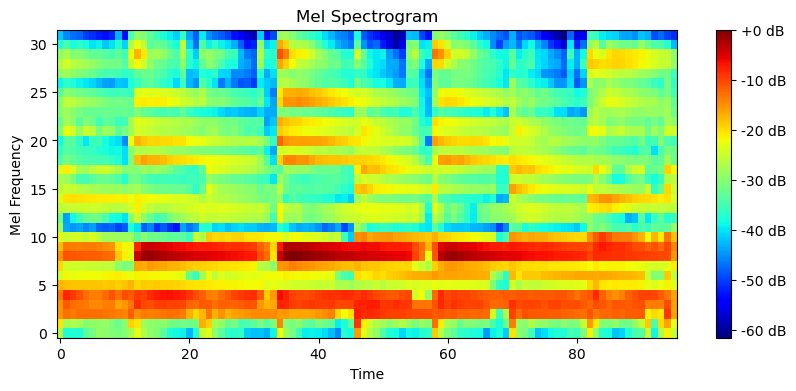

In [4]:
print(audioData.shape)
print(audioLabels.shape)
newData = []
newDataLabels = []
for i in range(5):
    num_entries = (audioLabels == i).sum().item()

    print(f"Number of entries equal to {i}: {num_entries}")



firstData = audioData[0,:,:]
show_audio(firstData)

It shows that there is a strong bias -> we have to perform data augmentation to upsample and downsample the spectogram data

# PCA Analysis

Explained variance ratio: [4.40291226e-01 1.12206928e-01 8.58464912e-02 5.50754145e-02
 3.18860523e-02 1.72867868e-02 1.40592726e-02 1.34350415e-02
 1.10818893e-02 1.06247440e-02 9.69298277e-03 8.41152854e-03
 8.13524425e-03 6.74997503e-03 6.44651428e-03 5.57982083e-03
 5.45520196e-03 5.35677653e-03 5.27318008e-03 4.64019692e-03
 4.25063260e-03 3.97316366e-03 3.82444961e-03 3.61547922e-03
 3.05362744e-03 2.94614630e-03 2.67392118e-03 2.52908166e-03
 2.36358983e-03 2.30340147e-03 2.20965478e-03 2.18095654e-03
 1.96802849e-03 1.94373028e-03 1.91033608e-03 1.76975108e-03
 1.68136891e-03 1.58319413e-03 1.55183638e-03 1.52698788e-03
 1.35038537e-03 1.33253401e-03 1.29079027e-03 1.23023300e-03
 1.20106048e-03 1.19096693e-03 1.09659636e-03 1.03204581e-03
 1.01737713e-03 1.00739079e-03 9.85189457e-04 9.47172113e-04
 9.24905413e-04 8.97281861e-04 8.66664515e-04 8.56139173e-04
 8.42546753e-04 8.36640946e-04 8.22553062e-04 8.08321813e-04
 7.71531137e-04 7.47185783e-04 7.25506397e-04 6.92621979e-0

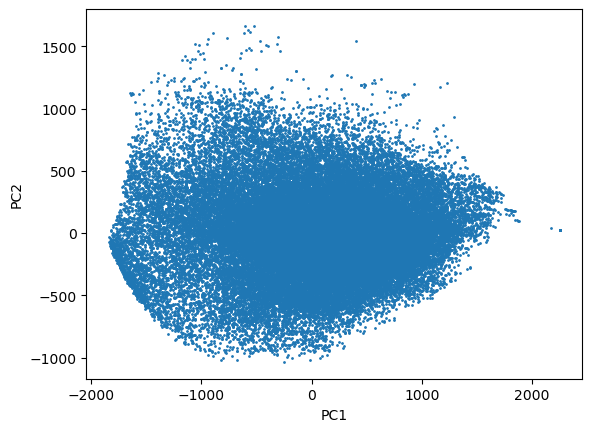

Explained variance by the first 100 PCAs:  0.9479215464962181


In [6]:
data = audioData.view(audioData.shape[0], -1).numpy()

pca = PCA(n_components=100)
pca.fit(data)

transformed_data = pca.transform(data)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the transformed data
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


print("Explained variance by the first 100 PCAs: ", sum(pca.explained_variance_ratio_))

# Histogram data
Next look at histogram data - maybe the learning can be performed on the histogram data

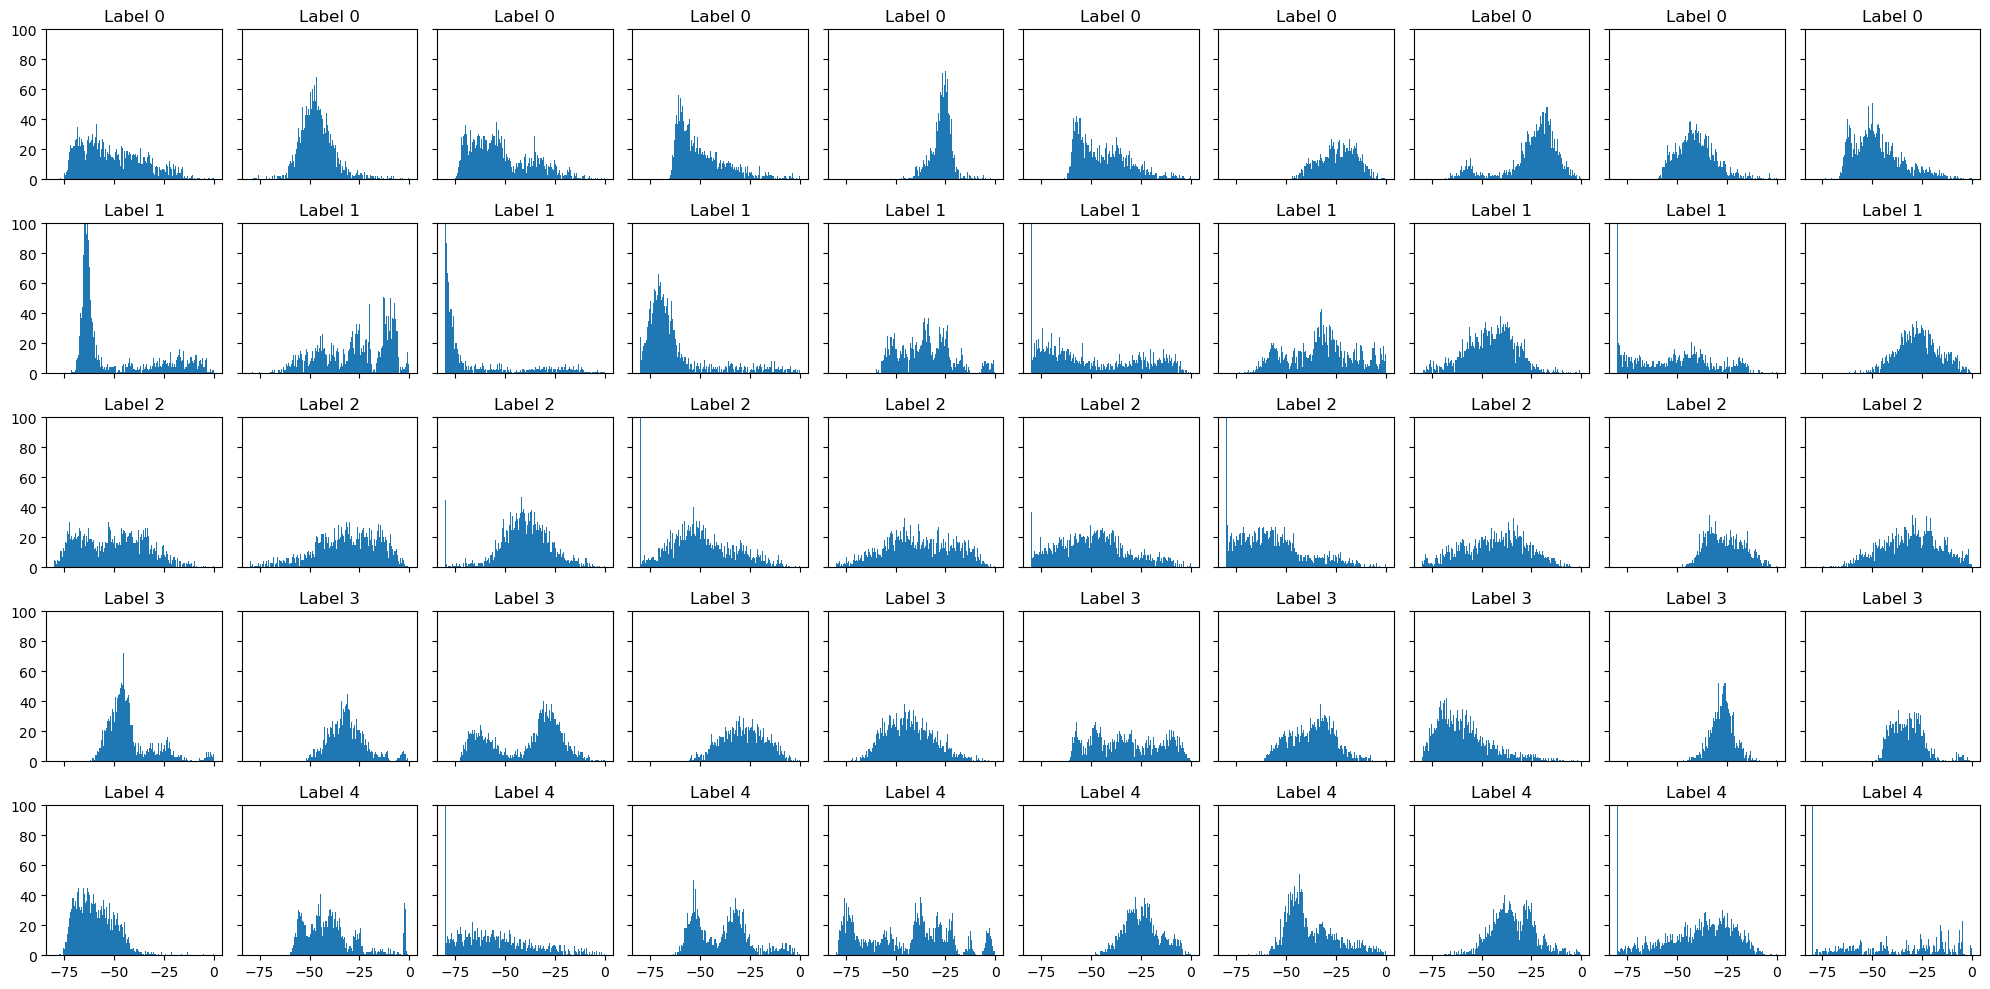

In [7]:
# look at histogram data

# get 10 images of each label
n_images = 10
labels = [0, 1, 2, 3, 4]
selected_indices = []
for label in labels:
    label_indices = np.where(audioLabels == label)[0]
    selected_indices.extend(np.random.choice(label_indices, n_images, replace=False))

# plot histograms
n_bins = 256
fig, axs = plt.subplots(5, 10, figsize=(20, 10), sharex=True, sharey=True)
for i, idx in enumerate(selected_indices):
    label = audioLabels[idx]
    img = audioData[idx]
    axs[label, i % n_images].hist(img.flatten(), bins=n_bins)
    axs[label, i % n_images].set_title(f"Label {label}")
    plt.ylim([0,100])
plt.tight_layout()
plt.show()

# Data Preperation for the Machine Learning Algorithm

The data corresponds to (52890 x 32 x 96) 52890 sound samples with 96 time frames where each one contains 32 frequency bands.

### Upsampling
For upsampling time or/and frequency spectrum of the mel spectogram data is masked.

torch.Size([32, 96])
torch.Size([1, 32, 96])


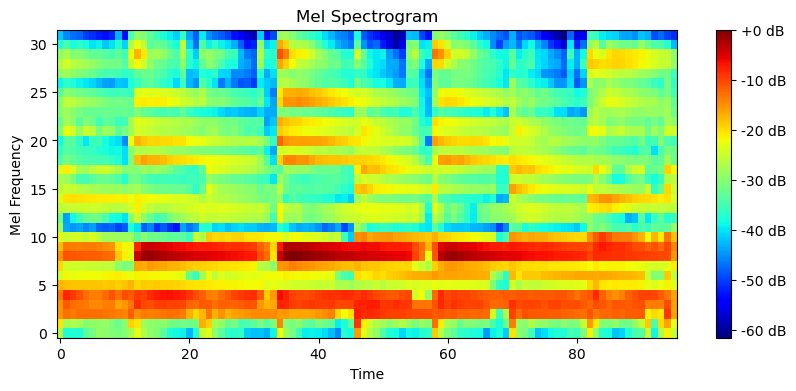

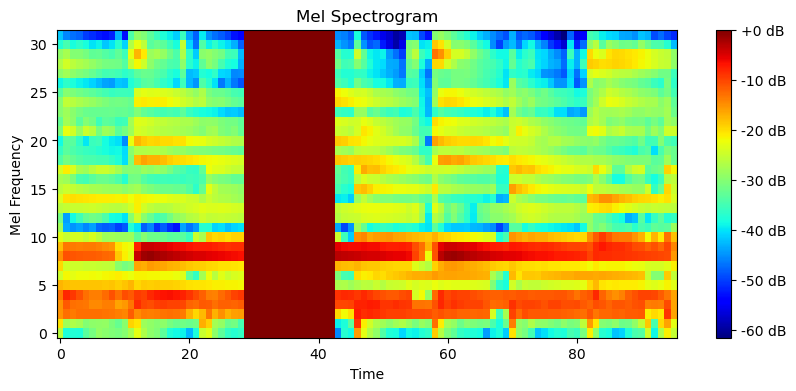

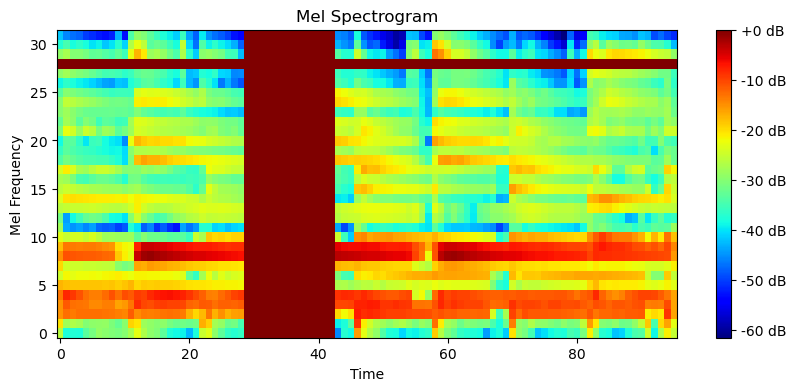

In [5]:
# apply data augemtation 
# try masking freq and time periods

time_masking = T.TimeMasking(time_mask_param = 18)
freq_masking = T.FrequencyMasking(freq_mask_param=12)

original_melspec = audioData[0,:,:]
print(original_melspec.shape)
original_melspec = original_melspec[np.newaxis, :]
print(original_melspec.shape)
show_audio(original_melspec.reshape(32, 96))
augmented_melspec = time_masking(original_melspec)
show_audio(augmented_melspec.reshape(32, 96))
augmented_melspec = freq_masking(augmented_melspec)


show_audio(augmented_melspec.reshape(32, 96))

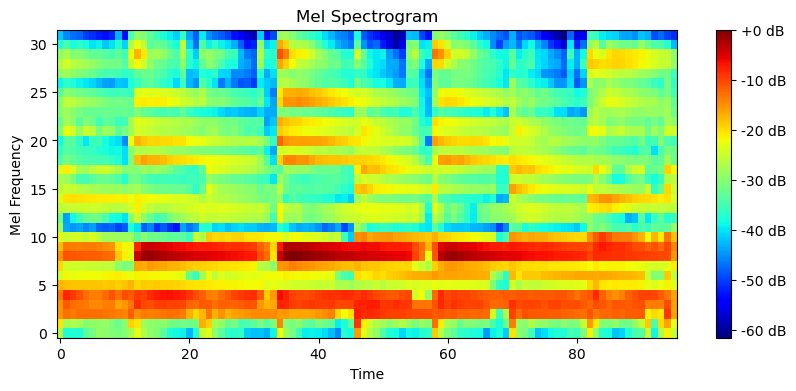

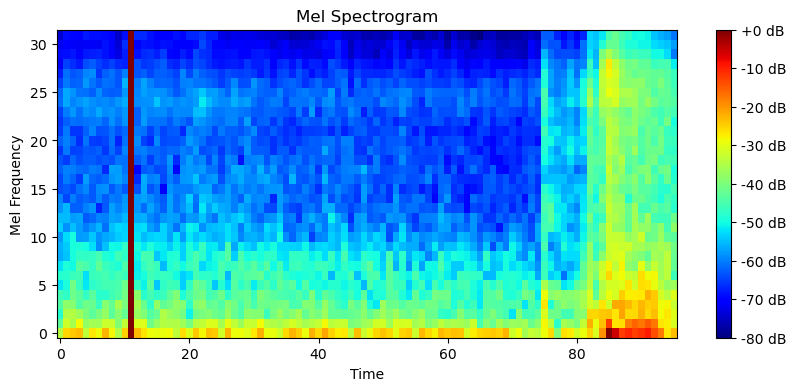

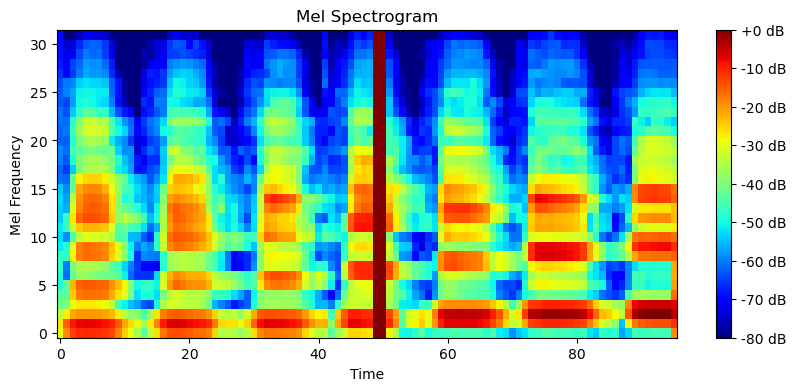

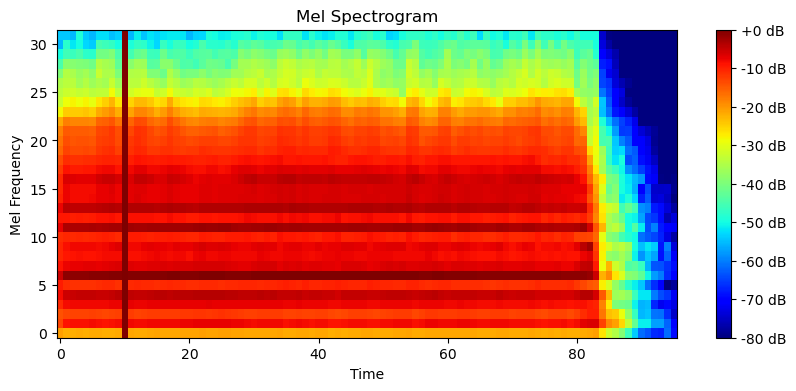

In [6]:
def augment_time(frame, p):
  time_masking = T.TimeMasking(time_mask_param = p)
  augmented_melspec = time_masking(frame)
  return augmented_melspec

def augment_freq(frame, p):
  freq_masking = T.FrequencyMasking(freq_mask_param=p)
  augmented_melspec = freq_masking(frame)
  return augmented_melspec


def spec_augment(original_melspec, num_data,
                 freq_masking_max = 12, 
                 time_masking_max= 20):
    # input 3D array

    augmented_melspec = np.empty((0, 32, 96)) #original_melspec.clone()
    counter = 0
    leng = original_melspec.shape[0]

    while counter < num_data:
    # for spec in range(original_melspec.shape[0]):
      frame = original_melspec[counter%leng,:,:]
      frame = frame[np.newaxis, :]
      choice = random.randint(0, 2)
      p_time = random.randint(5, freq_masking_max)
      p_freq = random.randint(5, time_masking_max)
      if choice == 0 or choice == 2:
        frame = augment_time(frame, p_time)
      elif choice == 1 or choice == 2:
        frame = augment_freq(frame, p_freq)
      augmented_melspec = np.append(augmented_melspec, frame, axis=0)
      counter += 1
    return augmented_melspec

# test 
audioDataAugm = spec_augment(audioData[0:10,:,:], 20)
show_audio(audioDataAugm[0,:,:].reshape(32, 96))
show_audio(audioDataAugm[1,:,:].reshape(32, 96))
show_audio(audioDataAugm[2,:,:].reshape(32, 96))
show_audio(audioDataAugm[19,:,:].reshape(32, 96))

### Undersampling
Select only maxSamples per class. Sample more from class 0 since it is a "Other" category where our model has to learn on more examples.

In [7]:
def undersample_data(data, labels, maxSamples):
  # Initialize variables to store the undersampled data and labels
  undersampled_data = []
  undersampled_labels = []

  # add all data from the OTHER class
  # Get the indices of the samples in the current class
  indices = np.where(labels == 0)[0]
  np.random.shuffle(indices)
  undersampled_indices = indices[:7500]
  undersampled_data.append(data[undersampled_indices])
  undersampled_labels.append(labels[undersampled_indices])


  # Iterate over each class
  for i in range(1, 5):
      # Get the indices of the samples in the current class
      indices = np.where(labels == i)[0]
      
      np.random.shuffle(indices)

      if maxSamples > len(indices):
        undersampled_indices = indices
      else:
        undersampled_indices = indices[:maxSamples]
      
      # Add the undersampled data and labels to the respective variables
      undersampled_data.append(data[undersampled_indices])
      undersampled_labels.append(labels[undersampled_indices])

  # Concatenate the undersampled data and labels for all classes
  undersampled_data = np.concatenate(undersampled_data, axis=0)
  undersampled_labels = np.concatenate(undersampled_labels, axis=0)

  undersampled_data = torch.Tensor(undersampled_data)
  undersampled_labels = torch.Tensor(undersampled_labels)

  print(undersampled_data.shape)
  print(undersampled_labels.shape)
  return undersampled_data, undersampled_labels

Perform the downsampling and upsampling on the dataset

In [10]:
# first downsample 
undersampled_data, undersampled_labels = undersample_data(audioData, audioLabels,4500)
augData = undersampled_data
augLabels = undersampled_labels


# then upsample
ups = [1500, 1500, 1500, 1600, 4200]    # number of datapoints to upsample
for i in range(5):

  indices_up = np.where(undersampled_labels == i)[0]
  data_up = undersampled_data[indices_up]
  labels_up = undersampled_labels[indices_up]
  augm_data = spec_augment(data_up, ups[i])
  lbls = i * torch.ones(ups[i])
  augm_data = torch.Tensor(augm_data)
  augData = torch.cat((augData, augm_data),0)
  augLabels = torch.cat((augLabels, lbls),0)


print(augData.shape)
print(augLabels.shape)

torch.Size([22697, 32, 96])
torch.Size([22697])
torch.Size([32997, 32, 96])
torch.Size([32997])


Let's check how many samples we have per class now

In [11]:
for i in range(5):
    num_entries = (augLabels == i).sum().item()
    print(f"Number of entries equal to {i}: {num_entries}")

Number of entries equal to 0: 9000
Number of entries equal to 1: 6000
Number of entries equal to 2: 6000
Number of entries equal to 3: 6012
Number of entries equal to 4: 5985


# Machine Learning Models

### Random Forest

In [ ]:
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = augData.reshape(-1, 96*32)
y = augLabels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest classifier
clf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42)
clf.fit(X_train, y_train)

# Evaluate performance on test set
score = clf.score(X_test, y_test)
print("Accuracy:", score)

### Support Vector machines

In [ ]:
poly = svm.SVC(kernel='poly', degree=3, C=2, decision_function_shape='ovo')
poly = poly.fit(X_train, y_train)

sig_pred = poly.predict(X_test)
print(sig_pred)

accuracy = accuracy_score(y_test, sig_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

print("Confusion Matrix")
cm_sig = confusion_matrix(y_test, sig_pred)
print(cm_sig)


In [ ]:
import pickle
# Save the trained classifier to a file
with open('svm_classifier.pickle', 'wb') as f:
    pickle.dump(poly, f)

### Convolutional Neural Networks

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.fc1 = nn.Linear(in_features=128*4*12, out_features=512)
        self.drop1 = nn.Dropout(p=0.5)
        self.relu4 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=512, out_features=5)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu4(x)
        
        x = self.fc2(x)
        
        return x

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 12
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):

 
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        print(batch_X.shape)
        optimizer.zero_grad()
        outputs = model(batch_X)
        print(outputs)
        print(batch_y)
        print(batch_y.shape)
        print(outputs.shape)


        predicted_classes = torch.max(outputs, dim=1)[1]
        predicted_classes_c = predicted_classes.contiguous()
        print(type(predicted_classes))
        out = predicted_classes_c.float()  #predicted_classes.type(torch.FloatTensor) #.to(torch.float32)
        print(out)
        print(predicted_classes.shape)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
with torch.no_grad():
    model.eval()  

    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

    total = y_test.size(0)
    correct = (predicted == y_test).sum().item()

    accuracy = (correct / total) * 100.0      

    print("Test Accuracy: " + str(accuracy))